In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.style.use("dark_background")

## Update rule:

for a single GCN layer, with $N$ nodes and $D$ features, the update rule is the following:
$$
H^{(l+1)} = \sigma \left( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)} \right)
$$

Where:

$H^{(l)}$: Feature matrix of shape $(N, D)$ in layer $l$

$\tilde A = A + I$: Adjacency matrix of graph with self-loops

$\tilde D$: Degree matrix of $\tilde A$

$\tilde D^{-\frac{1}{2}}$: Matrix D raised to the power of $-{\frac{1}{2}}$, for normalization purposes

$W$: Learnable weight parameter

$\sigma$: The sigmoid function

In [39]:
class GCNLayer(nn.Module):
  def __init__(self, in_features, out_features, device=device):
    super(GCNLayer, self).__init__()
    self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
    nn.init.xavier_uniform_(self.W)
    
  def forward(self, X, A):
    A_tilde = (A + torch.eye(A.shape[0]))
    degrees = torch.sum(A_tilde, dim=1)
    D_inv_sqrt = torch.diag(torch.pow(degrees, -1/2))
    normalized_adjacency = torch.mm(D_inv_sqrt, torch.mm(A_tilde, D_inv_sqrt)).to(device)
    output = torch.mm(normalized_adjacency, X.to(device))
    output = torch.mm(output, self.W)
    return output

In [40]:
class GCN(nn.Module):
  def __init__(self, n_layers, n_features, out_features, n_classes, dropout, device=device):
    super(GCN, self).__init__()
    self.layers = nn.ModuleList()
    self.layers.append(GCNLayer(n_features, n_hidden).to(device))
    if n_layers > 2:
      for _ in range(n_layers - 2):
        self.layers.append(GCNLayer(n_hidden, n_hidden).to(device))
    self.layers.append(GCNLayer(n_hidden, out_features).to(device))
    self.dropout = dropout
    
  def forward(self, X, A):
    hidden = self.layers[0](X, A)
    hidden = torch.relu(hidden)
    hidden = nn.functional.dropout(hidden, p=self.dropout, training=self.training)
    for layer in self.layers[1:-1]:
      hidden = layer(hidden, A)
      hidden = torch.relu(hidden)
      hidden = nn.functional.dropout(hidden, p=self.dropout, training=self.training)
    hidden = self.layers[-1](hidden, A)
    return hidden

In [6]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00a 0:00:01


In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]

X = data.x
edge_index = data.edge_index
Y = data.y
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

n_nodes = data.num_nodes
n_features = data.num_features
n_classes = dataset.num_classes

Processing...
Done!


In [ ]:
n_nodes, n_features, n_classes

(2708, 1433, 7)

In [24]:
def edge_index_to_adj(edge_index, n_nodes):
  A = torch.zeros((n_nodes, n_nodes))
  A[edge_index[0], edge_index[1]] = 1
  A[edge_index[1], edge_index[0]] = 1
  return A

In [9]:
A = edge_index_to_adj(edge_index, n_nodes)

In [10]:
n_hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
epochs = 200
n_layers = 2

In [45]:
model = GCN(n_layers=2, n_features=n_features, out_features=n_hidden, n_classes=n_classes, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

Epoch 0 - Loss: 2.7503, Accuracy: 0.0929
Epoch 10 - Loss: 1.2614, Accuracy: 0.7357
Epoch 20 - Loss: 0.5220, Accuracy: 0.8929
Epoch 30 - Loss: 0.2230, Accuracy: 0.9571
Epoch 40 - Loss: 0.1092, Accuracy: 0.9929
Epoch 50 - Loss: 0.0936, Accuracy: 0.9857
Epoch 60 - Loss: 0.0745, Accuracy: 1.0000
Epoch 70 - Loss: 0.0450, Accuracy: 0.9929
Epoch 80 - Loss: 0.0449, Accuracy: 1.0000
Epoch 90 - Loss: 0.0501, Accuracy: 1.0000
Epoch 100 - Loss: 0.0495, Accuracy: 1.0000
Epoch 110 - Loss: 0.0511, Accuracy: 0.9929
Epoch 120 - Loss: 0.0385, Accuracy: 0.9929
Epoch 130 - Loss: 0.0477, Accuracy: 1.0000
Epoch 140 - Loss: 0.0570, Accuracy: 0.9857
Epoch 150 - Loss: 0.0380, Accuracy: 0.9929
Epoch 160 - Loss: 0.0405, Accuracy: 1.0000
Epoch 170 - Loss: 0.0311, Accuracy: 1.0000
Epoch 180 - Loss: 0.0461, Accuracy: 1.0000
Epoch 190 - Loss: 0.0324, Accuracy: 1.0000
Test Loss: 0.6365, Test Accuracy: 0.8100


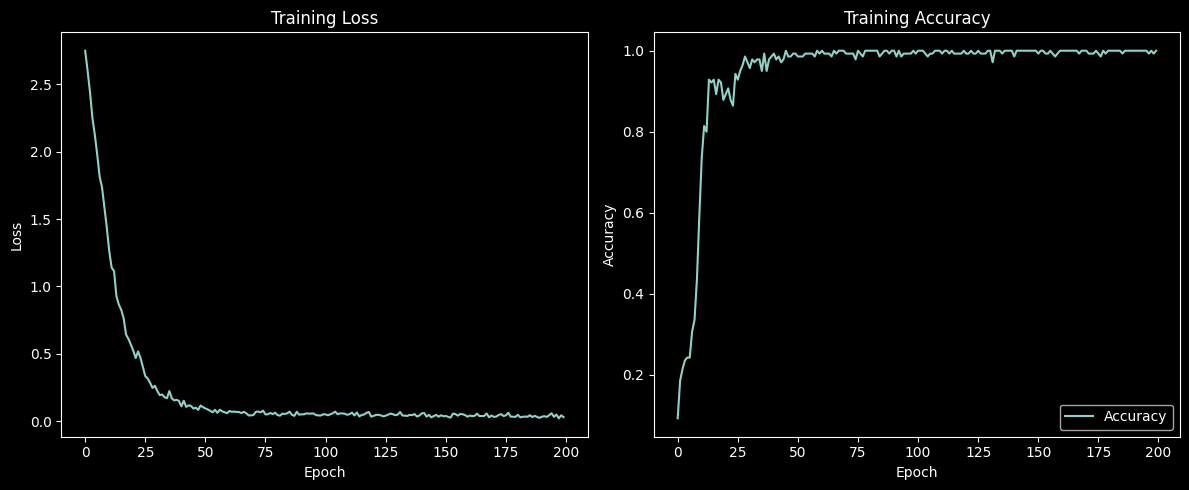

In [46]:
losses = []
accuracies = []
Y = Y.to(device)

for epoch in range(epochs):    
    model.train()
    optimizer.zero_grad()
    output = model(X, A).to(device)
    loss = criterion(output[train_mask], Y[train_mask])
    losses.append(loss.item())
    pred = output.argmax(dim=1)
    correct = (pred[train_mask] == Y[train_mask]).sum().item()
    acc = correct / train_mask.sum().item()
    accuracies.append(acc)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

model.eval()
with torch.no_grad():
    output = model(X, A)
    loss = criterion(output[test_mask], Y[test_mask])
    pred = output.argmax(dim=1)
    correct = (pred[test_mask] == Y[test_mask]).sum().item()
    acc = correct / test_mask.sum().item()
    print(f'Test Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}')
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()